In [1]:
import numpy as np
from scipy.optimize import newton
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

In [2]:
#Define parameters given in problem
params = {
    "subpops": 4,
     "recovery_rate": 3,
     "contact_rate": 0.45,
     "susceptibility_probabilities": [1,2,3,4],
     "groupwise_population": [1000, 1000, 1000, 1000]
     }

class TimeDomain:

    def __init__(self, start_time: float, end_time: float, n_steps: int):
        self.start_time = start_time
        self.end_time = end_time 
        self.n_steps = n_steps
        self.spacing = (self.end_time - self.start_time) / (self.n_steps)
        self.array = np.linspace(self.start_time, self.end_time, self.n_steps+1)


class EulerSolver():
    def solve(
            self,
            time_domain: TimeDomain,
            model,
            initial_conditions: np.array,
    ):
        solution_buffer = []
        solution_buffer.append(initial_conditions)
        for t in time_domain.array:
            y_new = solution_buffer[-1] + time_domain.spacing * (model.rhs(solution_buffer[-1], t))
            solution_buffer.append(y_new)
        return np.array(solution_buffer)

In [9]:
# Multiple Population Infection Model

class Multipop():
    def __init__(
        self, 
        *, 
        subpops: int,
        recovery_rate: float,
        contact_rate: float,
        susceptibility_probabilities: list,
        groupwise_population: list,
    ) -> None:
        self.subpops=subpops
        self.recovery_rate=recovery_rate
        self.contact_rate=contact_rate
        self.susceptibility_probabilities=np.array(susceptibility_probabilities)
        self.groupwise_population=groupwise_population
        self.ones = np.ones(self.subpops)

    def rhs(self, state: np.array, time:float):
        ret = np.empty_like(state)
        infections = state[:self.subpops]
        recoveries = state[self.subpops:]
        new_infections = self.contact_rate * self.susceptibility_probabilities * (1-infections-recoveries) * (self.ones@infections) - (self.recovery_rate * infections)
        new_recoveries = self.recovery_rate * infections
        ret[:self.subpops] = new_infections
        ret[self.subpops:] = new_recoveries
        return ret
    
    def get_epidemic_initial_conditions(self, rate):
        ret = self.subpops * [rate]
        ret = ret + self.subpops * [0]
        return ret

In [10]:
# Establish needed model stuff

mpi_model = Multipop(**params)
time = TimeDomain(0, 10, 1_000)
solver = EulerSolver()

# Simulate multiple population infection(s)

initial_conditions = mpi_model.get_epidemic_initial_conditions(0.1)
mpi_solution = solver.solve(time, mpi_model, np.array(initial_conditions))


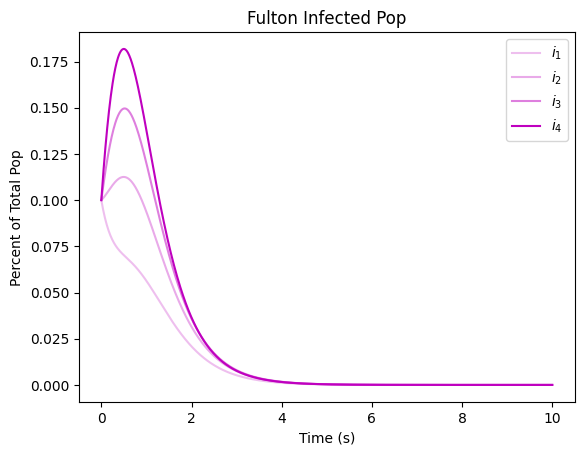

In [12]:
# Plot Infected Percentage

titles = ["Susceptable", "Infected", "Recovered"]
fig, ax = plt.subplots(1, 1)
labels = ["$i_1$", "$i_2$", "$i_3$", "$i_4$"]
for populate in range(mpi_model.subpops):
    ax.plot(time.array, mpi_solution[:, populate][:-1], 'm', alpha=1/(mpi_model.subpops - populate),label=labels[populate])


ax.set_xlabel("Time (s)")
ax.set_ylabel("Percent of Total Pop")
ax.set_title("Fulton Infected Pop")
ax.legend()

plt.show()

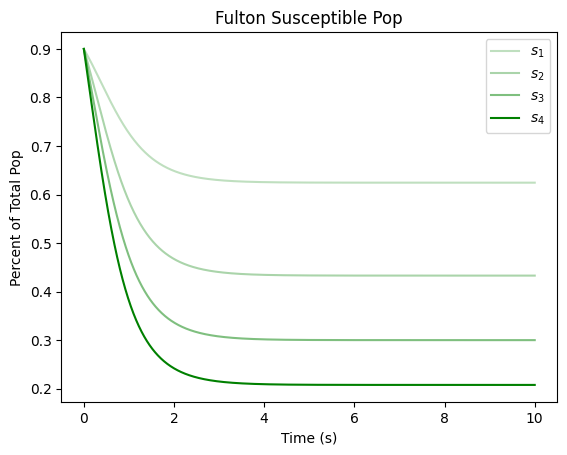

In [16]:
# Specify SIR for plotting

inf = mpi_solution[:, :mpi_model.subpops]
recv = mpi_solution[:, mpi_model.subpops:]
sus = 1-inf-recv
weighted_p = np.sum(sus * mpi_model.susceptibility_probabilities, axis=1)/np.sum(sus, axis=1)

# Plot Susceptible Percentage

fig, ax = plt.subplots(1, 1)
labels = ["$s_1$", "$s_2$", "$s_3$", "$s_4$"]
for populate in range(mpi_model.subpops):
    ax.plot(time.array, sus[:, populate][:-1], 'g', alpha=1/(mpi_model.subpops - populate), label=labels[populate])

ax.set_xlabel("Time (s)")
ax.set_ylabel("Percent of Total Pop")
ax.set_title("Fulton Susceptible Pop")
ax.legend()
plt.show()

Text(0.5, 1.0, 'Fulton Susceptibility')

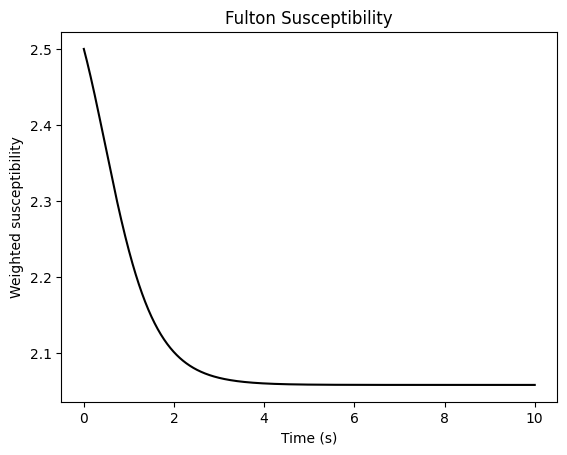

In [17]:
# Plot Weighted Susceptible

fig, ax = plt.subplots(1, 1)

ax.plot(time.array, weighted_p[:-1],'k')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Weighted susceptibility")
ax.set_title("Fulton Susceptibility")
